In [57]:
import numpy as np
from scipy.linalg import eigh
from scipy.sparse import diags
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt


In [75]:
def create_reflective_laplacian(n):
    N = n * n  # Total number of points in the grid
    M = np.zeros((N, N))  # Initialize matrix with zeros

    for i in range(N):
        # Default value for cells
        M[i, i] = -4
        
        # Reflective boundary adjustments
        if i % n == 0 or i % n == (n - 1):  # Left or right edge
            M[i, i] += 1
        if i < n or i >= N - n:  # Top or bottom edge
            M[i, i] += 1

        # Set connections for adjacent cells, considering the grid layout
        if i % n != 0:  # Not on the left edge
            M[i, i - 1] = 1  # Left neighbor
        if (i + 1) % n != 0:  # Not on the right edge
            M[i, i + 1] = 1  # Right neighbor
        if i >= n:  # Not on the top edge
            M[i, i - n] = 1  # Top neighbor
        if i < N - n:  # Not on the bottom edge
            M[i, i + n] = 1  # Bottom neighbor

    return M

# Example usage
n = 4 # Change this to create a different size grid
L = create_reflective_laplacian(n)
print(L)


[[-2.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -3.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -3.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -2.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0. -3.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  1. -3.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0. -3.  1.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -3.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0. -2.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -3.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -3. 

In [68]:
# Solve the eigenvalue problem
eigenvalues, eigenvectors = eigh(L)

# Print the results
print("Eigenvalues:")
print(eigenvalues)
print("\nEigenvectors (each column is one eigenvector):")
print(eigenvectors)

Eigenvalues:
[-6.82842712e+00 -5.41421356e+00 -5.41421356e+00 -4.00000000e+00
 -4.00000000e+00 -4.00000000e+00 -3.41421356e+00 -3.41421356e+00
 -2.58578644e+00 -2.58578644e+00 -2.00000000e+00 -2.00000000e+00
 -1.17157288e+00 -5.85786438e-01 -5.85786438e-01  7.67864560e-16]

Eigenvectors (each column is one eigenvector):
[[ 0.0732233  -0.19112191 -0.00916877 -0.09891701  0.33845252  0.02579376
  -0.19036907  0.01926833  0.4613642  -0.02305254 -0.33664257 -0.10803601
   0.4267767   0.22326472  0.40440229 -0.25      ]
 [-0.1767767   0.31978222  0.15079567 -0.16969287 -0.43292925  0.18378411
   0.16750436  0.31135557 -0.15143105 -0.31948182  0.10803601 -0.33664257
   0.1767767   0.27631869  0.22056288 -0.25      ]
 [ 0.1767767  -0.11949154 -0.33274881  0.06109082  0.05543777 -0.49314761
  -0.3386051  -0.10171816 -0.33298569 -0.11882984  0.10803601 -0.33664257
  -0.1767767   0.35134832 -0.03942531 -0.25      ]
 [-0.0732233  -0.00916877  0.19112191  0.20751906  0.03903896  0.28356974
   0.01

In [69]:
def create_circular_laplacian(n, radius):
    # Total points
    N = n * n
    # Center of the circle
    center = np.array([n / 2 - 0.5, n / 2 - 0.5])
    # Initialize the matrix
    M = np.zeros((N, N))

    # Identify points inside the circle
    inside_circle = []
    for i in range(n):
        for j in range(n):
            if (np.array([i, j]) - center).dot(np.array([i, j]) - center) <= radius**2:
                inside_circle.append(i * n + j)

    # Now build the Laplacian only for these points
    for idx in inside_circle:
        x, y = divmod(idx, n)
        M[idx, idx] = -4
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < n and 0 <= ny < n and nx * n + ny in inside_circle:
                M[idx, nx * n + ny] = 1

    # Filter out the unused rows and columns
    M = M[np.ix_(inside_circle, inside_circle)]

    return M

L = 1
# Create the corrected Laplacian for the circular domain
radius = L / 2  # Make sure L and n are defined
L_circle_corrected = create_circular_laplacian(n, radius * n / L)

# Now, check if the matrix is square
if L_circle_corrected.shape[0] == L_circle_corrected.shape[1]:
    print("The matrix is square.")
    # Proceed with solving the eigenvalue problem
    try:
        vals_circle, vecs_circle = eigh(L_circle_corrected)
        # Continue with your analysis or plotting
    except ValueError as e:
        print("Error in eigenvalue computation:", e)
else:
    print("The matrix is not square, check the Laplacian construction.")


The matrix is square.


In [70]:

# Square grid (already done)
L_square = create_reflective_laplacian(n)

# Rectangle grid
L_rect = create_reflective_laplacian(2 * n)  # Assuming 2n x n rectangle

# Circular grid
radius = L / 2  # Make sure L and n are defined
L_circle = create_circular_laplacian(n, radius * n / L)
try:
    vals_circle, vecs_circle = eigh(L_circle)
    # If successful, continue to plot or use the eigenvalues and vectors
except ValueError as e:
    print(f"An error occurred: {e}")

In [71]:
# Solve the eigenvalue problem for each shape
vals_square, vecs_square = eigh(L_square)
vals_rect, vecs_rect = eigh(L_rect)
vals_circle, vecs_circle = eigh(L_circle)

In [72]:

# Function for plotting the eigenvectors
def plot_eigenvectors(vals, vecs, title, shape, n, plot_number=4):
    """
    Plot the first few eigenvectors for a given shape.

    Args:
        vals (array): Eigenvalues.
        vecs (matrix): Eigenvectors.
        title (str): Title for the plots.
        shape (str): 'square', 'rectangle', or 'circle' to indicate the shape.
        n (int): Grid size (number of points per side for square and circle, width for rectangle).
        plot_number (int): Number of eigenvectors to plot.
    """
    fig, axs = plt.subplots(1, plot_number, figsize=(15, 3))
    fig.suptitle(title)
    
    for i in range(plot_number):
        if shape == 'circle':
            # Special handling for circle to only show the circular part
            eigenvector = np.zeros((n, n))
            idx = 0
            for x in range(n):
                for y in range(n):
                    if (x - n/2)**2 + (y - n/2)**2 <= (n/2)**2:
                        eigenvector[x, y] = vecs[idx, i]
                        idx += 1
        else:
            eigenvector = vecs[:, i].reshape(n, -1) if shape == 'square' else vecs[:, i].reshape(-1, n)
        
        axs[i].imshow(eigenvector, cmap='viridis')
        axs[i].set_title(f'λ = {vals[i]:.2f}')
        axs[i].axis('off')
    plt.show()

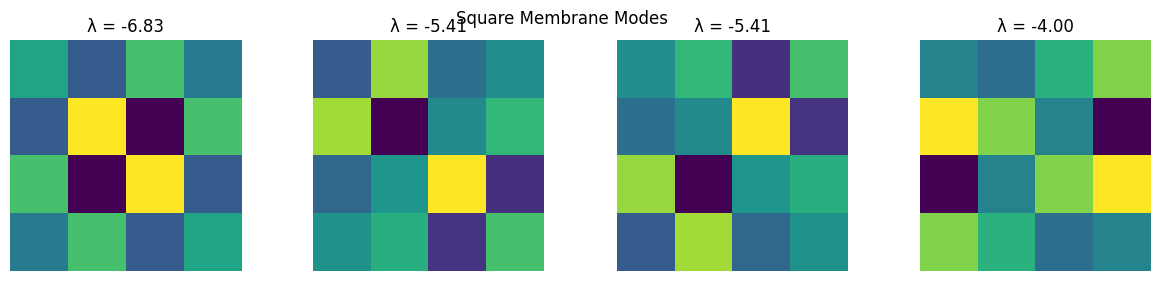

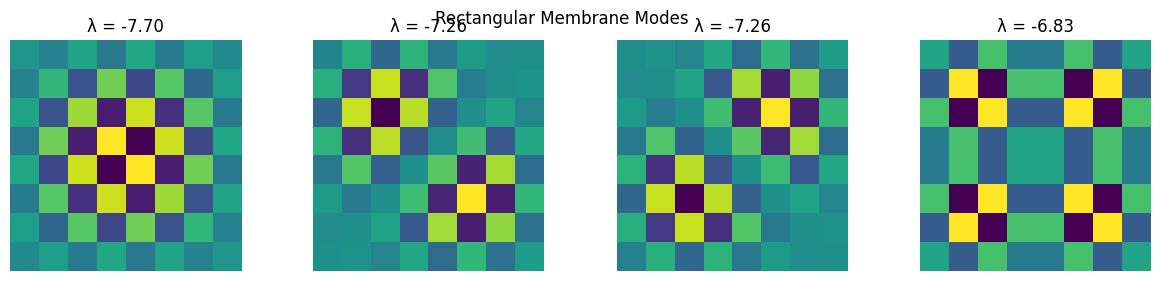

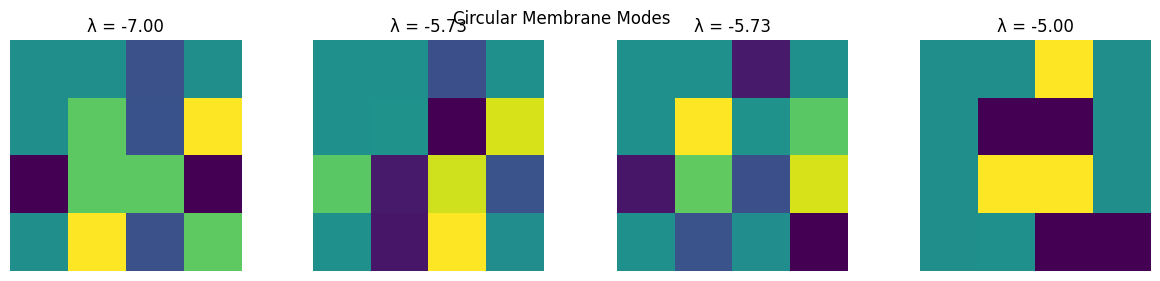

In [73]:
# Plot the eigenvectors for each shape
plot_eigenvectors(vals_square, vecs_square, 'Square Membrane Modes', 'square', n)
plot_eigenvectors(vals_rect, vecs_rect, 'Rectangular Membrane Modes', 'rectangle', 2*n)
plot_eigenvectors(vals_circle, vecs_circle, 'Circular Membrane Modes', 'circle', n)